In [4]:
#!pip install nltk
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet

# Define the phrase for which you want to find related words
phrase = "game features"

# Tokenize the phrase into individual words
words = phrase.split()

related_words = []

# Iterate through the words in the phrase and find related words
for word in words:
    synsets = wordnet.synsets(word)
    for synset in synsets:
        for lemma in synset.lemmas():
            related_words.append(lemma.name())

# Remove duplicates and sort the list
related_words = list(set(related_words))
related_words.sort()

# Print the list of related words for the phrase
for related_word in related_words:
    print(related_word)




back
bet_on
biz
boast
characteristic
crippled
feature
feature_article
feature_film
feature_of_speech
gage
game
gamey
gamy
gimpy
gritty
halt
halting
have
lame
lineament
mettlesome
plot
punt
secret_plan
spirited
sport
spunky
stake


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\royle\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [1]:
import pandas as pd
import numpy as np
import string
import nltk
import matplotlib.pyplot as plt
import warnings
from nltk import word_tokenize, pos_tag, FreqDist, SnowballStemmer
from nltk.corpus import wordnet as wn, stopwords
from gensim import corpora, models
from operator import itemgetter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from transformers import pipeline
from wordcloud import WordCloud
from nltk.util import ngrams

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
warnings.filterwarnings("ignore")

C:\Users\Michael\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
userComments1 = pd.read_csv('C:/Users/Michael/Documents/GitHub/EBAC/dataSources/videoGames/metacritic_game_user_comments (0-100k).csv')
userComments2 = pd.read_csv('C:/Users/Michael/Documents/GitHub/EBAC/dataSources/videoGames/metacritic_game_user_comments (100-200k).csv')
userComments3 = pd.read_csv('C:/Users/Michael/Documents/GitHub/EBAC/dataSources/videoGames/metacritic_game_user_comments (200-300k).csv')

userComments3['Unnamed: 0'] = userComments3['Unnamed: 0'].astype('float64')
userComments3['Userscore'] = userComments3['Userscore'].astype('float64')

userComments = pd.concat([userComments1, userComments2, userComments3], axis = 0)
userComments.drop(columns = 'Unnamed: 0', inplace = True)
userComments.dropna(how = 'all', inplace = True)

userComments.Platform.unique()

platformMap = {
'Nintendo64': 'Nintendo',
'GameBoyAdvance': 'Nintendo',
'3DS': 'Nintendo',
'DS': 'Nintendo',
'Wii': 'Nintendo',
'Switch': 'Nintendo',
'WiiU': 'Nintendo',
'GameCube': 'Nintendo',
'PlayStation': 'PlayStation',
'PlayStation3': 'PlayStation',
'PlayStation2': 'PlayStation',
'PlayStation4': 'PlayStation',
'PlayStationVita': 'PlayStation',
'PSP': 'PlayStation',
'Xbox360': 'Xbox',
'Xbox': 'Xbox',
'XboxOne': 'Xbox',
'PC': 'PC',
'Dreamcast': 'Others',
'not specified': 'Others'
}

userComments['platformCondensed'] = userComments.Platform.map(platformMap)

In [3]:
filter_list = ["would", "could", "left", "right", "a.m.", "p.m.", "'s", "! ! !", "...", ":", ";", "n't",
              "game", "games", "play", "fun", "much", "one", "great", "perfect", "time", "year", "lot", "thing", "etc",
              "hour", "hours", "way", "ways", "everything", "anything", "thing", "things", "review", "reviews", "year", "years",
              "feel", "feels", "thing", "nothing", "problem", "end", "begin", "kind", "piece", "work", "call", "anyone",
              "minute", "minutes", "waste", "crap", "garbage"]

def preprocess_text(tokens, needtokenizeBoolean = True, grams = False,  ngramsNumber = 2, furtherPreProcessNgrams = False):
    
    if needtokenizeBoolean:
        tokens = nltk.word_tokenize(tokens)
        if grams:
            tokens = list(ngrams(tokens, ngramsNumber))
    if grams:
        tokens = [' '.join(gram) for gram in tokens]
        if furtherPreProcessNgrams == False:
            return tokens

    tokens = [t.lower() for t in tokens]
    tokens = [t for t in tokens if t not in stopwords.words('english') + filter_list]
    tokens = [t for t in tokens if t not in string.punctuation]
    tokens = [t for t in tokens if not t.isnumeric()]
    tokens = [SnowballStemmer('english').stem(t) for t in tokens]

    return tokens

def wc(df, columnName, preProcessingFunctionBoolean = True, tfidfVectorizerBoolean = True, vectorizerMinDf = 2, vectorizerMaxDf = 0.7, countVectorizerBinary = True,
       nounTaggingBoolean = False, universalNounTagsetBoolean = False, ngrams = False, ngramsNumber = 2, furtherPreProcessNgrams = False,
       top = 10, features_improvements = 'Word Cloud', platform = 'All'):

    if preProcessingFunctionBoolean == True & ngrams == True:
        if tfidfVectorizerBoolean == True:
            if furtherPreProcessNgrams == True:
                tdm = TfidfVectorizer(tokenizer = lambda text: preprocess_text(text, grams = True, ngramsNumber=ngramsNumber, furtherPreProcessNgrams = True),
                                      min_df = vectorizerMinDf, max_df = vectorizerMaxDf)
            else:
                tdm = TfidfVectorizer(tokenizer = lambda text: preprocess_text(text, grams = True, ngramsNumber=ngramsNumber),
                                      min_df = vectorizerMinDf, max_df = vectorizerMaxDf)
        else:
            if furtherPreProcessNgrams == True:
                tdm = CountVectorizer(binary = countVectorizerBinary, tokenizer = lambda text: preprocess_text(text, grams = True, ngramsNumber=ngramsNumber, furtherPreProcessNgrams = True),
                                      min_df = vectorizerMinDf, max_df = vectorizerMaxDf)
            else:
                tdm = CountVectorizer(binary = countVectorizerBinary, tokenizer = lambda text: preprocess_text(text, grams = True, ngramsNumber=ngramsNumber),
                                      min_df = vectorizerMinDf, max_df = vectorizerMaxDf)
        tdmMatrix = tdm.fit_transform(df[columnName])
    
    if nounTaggingBoolean == True and ngrams == False:
        noun_list = []
        for value in df[columnName]:
            if universalNounTagsetBoolean == True:
                tagged_value = pos_tag(word_tokenize(value), tagset='universal')
                noun = [word for word, tag in tagged_value if tag == 'NOUN']
            else:
                tagged_value = pos_tag(word_tokenize(value))
                noun = [word for word, tag in tagged_value if tag == 'NN' or tag == 'NNS']
            noun_list.append(noun)
        df['Text_NounOnly'] = noun_list
        if preProcessingFunctionBoolean == True:
            df['Text_NounOnly'] = df['Text_NounOnly'].apply(lambda x: preprocess_text(tokens = x, needtokenizeBoolean = False))
            df['Text_NounOnly'] = df['Text_NounOnly'].apply(lambda x: ', '.join(x))
        else:
            df['Text_NounOnly'] = df['Text_NounOnly'].apply(lambda x: ', '.join(x))
        if tfidfVectorizerBoolean == True:
            tdm = TfidfVectorizer(min_df = vectorizerMinDf, max_df = vectorizerMaxDf)
        else:
            tdm = CountVectorizer(binary = countVectorizerBinary, min_df = vectorizerMinDf, max_df = vectorizerMaxDf)
        tdmMatrix = tdm.fit_transform(df['Text_NounOnly'])
        
    if nounTaggingBoolean != True and ngrams == False:
        if tfidfVectorizerBoolean == True:
            if preProcessingFunctionBoolean == True:
                tdm = TfidfVectorizer(tokenizer = preprocess_text, min_df = vectorizerMinDf, max_df = vectorizerMaxDf)
            else:
                tdm = TfidfVectorizer(min_df = vectorizerMinDf, max_df = vectorizerMaxDf)
        else:
            if preProcessingFunctionBoolean == True:
                tdm = CountVectorizer(binary = countVectorizerBinary, tokenizer = preprocess_text, min_df = vectorizerMinDf, max_df = vectorizerMaxDf)
            else:
                tdm = CountVectorizer(binary = countVectorizerBinary, min_df = vectorizerMinDf, max_df = vectorizerMaxDf)
        tdmMatrix = tdm.fit_transform(df[columnName])

    array = tdmMatrix.toarray()
    feature_names = tdm.get_feature_names_out()
    word_tfidf = dict(zip(feature_names, array.sum(axis=0)))
    fd_tfidf= FreqDist(word_tfidf)
    wc = WordCloud(background_color="white").generate_from_frequencies(fd_tfidf)
    plt.figure()
    plt.suptitle(f"{features_improvements} ({platform})", fontsize = 20, x = 0.5, y = 0.85, fontweight = 'bold', fontname = 'Calibri') 
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    displayList = []
    for x,y in fd_tfidf.most_common(top):
        displayList.append((x, round(y, 2)))

    plt.show()
    print(displayList)

In [4]:
userComments.shape

(283983, 6)

In [5]:
userCommentsTEST = userComments.sample(283983).copy()

In [6]:
userCommentsTEST.Userscore.value_counts().sort_index(ascending = False)

Userscore
10.0    112531
9.0      53489
8.0      30271
7.0      17052
6.0      12036
5.0      10113
4.0       7952
3.0       7118
2.0       5983
1.0       7318
0.0      20120
Name: count, dtype: int64

In [7]:
# Assumption: Game creators will want to focus on problems where they can fix and do better than improving what's already good (more weights on low userscores?)

userCommentsTESTNotNull = userCommentsTEST[userCommentsTEST.Comment.notnull()]

userCommentsTESTNotNull.loc[userCommentsTESTNotNull.Userscore > 9, 'scoreBin'] = 'High'
userCommentsTESTNotNull.loc[(userCommentsTESTNotNull.Userscore >= 3) & (userCommentsTESTNotNull.Userscore <= 9), 'scoreBin'] = 'Medium'
userCommentsTESTNotNull.loc[userCommentsTESTNotNull.Userscore < 3, 'scoreBin'] = 'Low'

userCommentsTESTHigh = userCommentsTESTNotNull[userCommentsTESTNotNull.scoreBin == 'High']
userCommentsTESTLow = userCommentsTESTNotNull[userCommentsTESTNotNull.scoreBin == 'Low']

In [8]:
platformCondensed_list = list(userCommentsTESTNotNull[userCommentsTESTNotNull.scoreBin != 'Medium'].platformCondensed.unique())
userCommentsTESTExtreme_list = [userCommentsTESTHigh, userCommentsTESTLow]

for platform in platformCondensed_list:
    for df in userCommentsTESTExtreme_list:
        print(f"{platform}, {df.reset_index().scoreBin[0]} Userscore; No. of comments: {df[df.platformCondensed == platform].shape[0]}")

PC, High Userscore; No. of comments: 43259
PC, Low Userscore; No. of comments: 18236
Xbox, High Userscore; No. of comments: 18096
Xbox, Low Userscore; No. of comments: 6371
Nintendo, High Userscore; No. of comments: 16357
Nintendo, Low Userscore; No. of comments: 1009
PlayStation, High Userscore; No. of comments: 34452
PlayStation, Low Userscore; No. of comments: 7781
Others, High Userscore; No. of comments: 358
Others, Low Userscore; No. of comments: 19


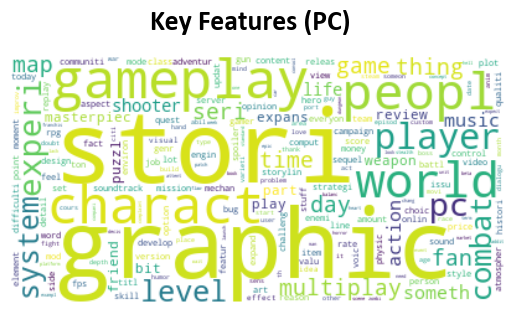

[('stori', 1529.31), ('graphic', 1372.68), ('gameplay', 1054.64), ('charact', 963.95), ('peopl', 902.82), ('world', 808.48), ('player', 757.24), ('pc', 671.61), ('experi', 643.0), ('combat', 561.67), ('level', 558.18), ('system', 521.25), ('multiplay', 516.9), ('fan', 508.97), ('thing', 499.32), ('seri', 479.96), ('day', 477.58), ('game', 464.18), ('time', 444.39), ('map', 441.81)]


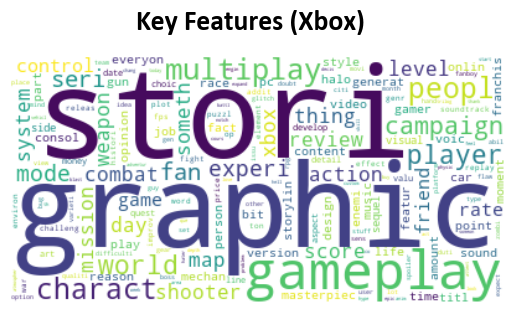

[('stori', 690.9), ('graphic', 590.15), ('gameplay', 481.47), ('multiplay', 434.55), ('peopl', 404.97), ('charact', 400.06), ('player', 331.21), ('world', 330.26), ('campaign', 329.62), ('seri', 310.23), ('fan', 304.35), ('experi', 287.13), ('mode', 274.76), ('shooter', 225.01), ('level', 218.35), ('action', 214.72), ('combat', 213.3), ('thing', 212.59), ('xbox', 212.2), ('review', 210.1)]


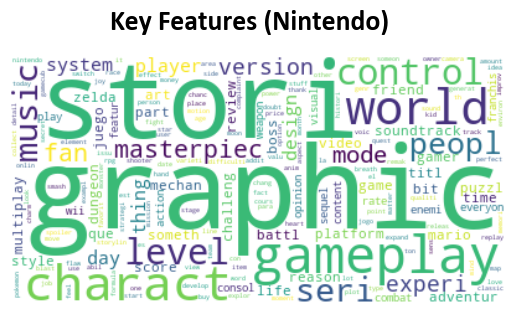

[('graphic', 526.31), ('stori', 495.46), ('gameplay', 427.97), ('charact', 402.32), ('world', 377.02), ('control', 354.32), ('level', 348.32), ('music', 307.93), ('seri', 307.83), ('peopl', 279.44), ('masterpiec', 248.01), ('fan', 239.24), ('mode', 225.23), ('experi', 217.11), ('version', 206.33), ('player', 203.27), ('system', 198.0), ('design', 197.51), ('thing', 194.69), ('day', 187.59)]


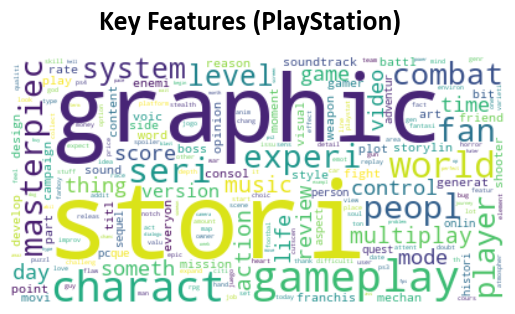

[('stori', 1556.59), ('graphic', 1205.94), ('gameplay', 1054.41), ('charact', 995.23), ('world', 695.95), ('seri', 656.53), ('peopl', 630.22), ('experi', 576.72), ('masterpiec', 558.96), ('fan', 544.55), ('combat', 519.74), ('player', 492.44), ('level', 442.52), ('system', 434.34), ('multiplay', 424.97), ('action', 417.13), ('music', 413.02), ('control', 383.64), ('mode', 383.33), ('game', 362.73)]


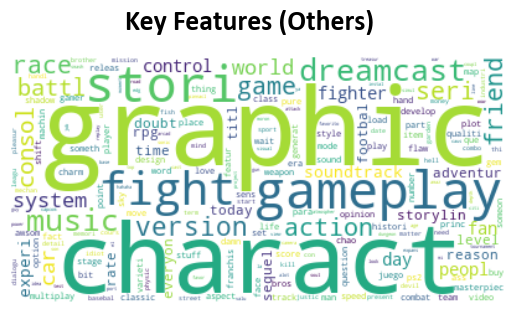

[('graphic', 17.08), ('charact', 14.11), ('gameplay', 11.72), ('stori', 11.03), ('fight', 10.6), ('dreamcast', 9.53), ('music', 9.19), ('version', 6.25), ('action', 5.76), ('seri', 5.57), ('race', 5.54), ('friend', 5.43), ('game', 5.29), ('battl', 5.02), ('consol', 5.02), ('system', 4.97), ('world', 4.91), ('car', 4.82), ('fighter', 4.76), ('day', 4.66)]


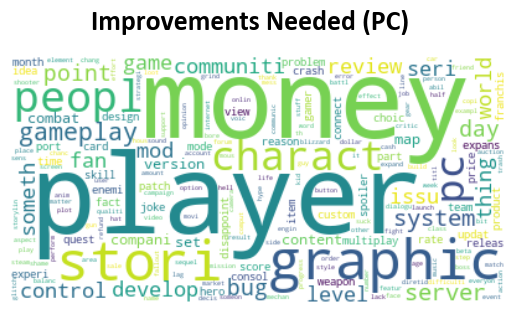

[('player', 445.29), ('money', 444.91), ('graphic', 403.92), ('stori', 396.69), ('peopl', 375.48), ('charact', 328.25), ('pc', 320.2), ('gameplay', 312.89), ('server', 281.24), ('system', 268.15), ('bug', 242.83), ('point', 230.3), ('day', 228.03), ('someth', 209.62), ('develop', 209.55), ('review', 207.04), ('level', 206.41), ('control', 204.82), ('mod', 204.76), ('communiti', 196.68)]


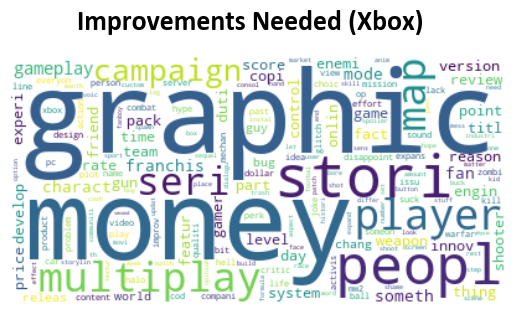

[('graphic', 181.28), ('money', 170.93), ('stori', 170.64), ('peopl', 168.87), ('player', 162.9), ('multiplay', 158.3), ('map', 156.5), ('seri', 141.59), ('campaign', 133.45), ('gameplay', 131.09), ('charact', 108.22), ('fan', 101.73), ('mode', 95.76), ('franchis', 93.58), ('someth', 88.75), ('weapon', 79.89), ('point', 78.9), ('gun', 77.04), ('pack', 76.83), ('review', 75.89)]


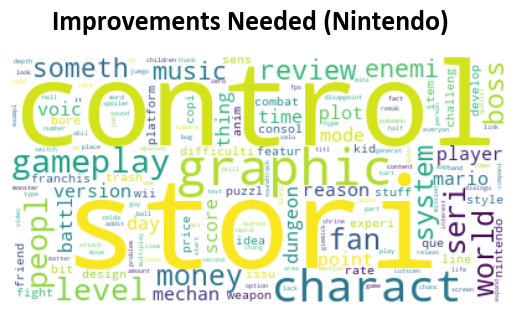

[('stori', 35.42), ('control', 35.19), ('graphic', 34.23), ('charact', 28.12), ('gameplay', 27.35), ('peopl', 22.72), ('level', 21.83), ('seri', 19.97), ('money', 17.66), ('fan', 17.43), ('world', 16.71), ('review', 15.45), ('system', 15.09), ('boss', 14.9), ('someth', 14.31), ('music', 13.26), ('enemi', 12.91), ('player', 12.84), ('version', 12.65), ('time', 12.42)]


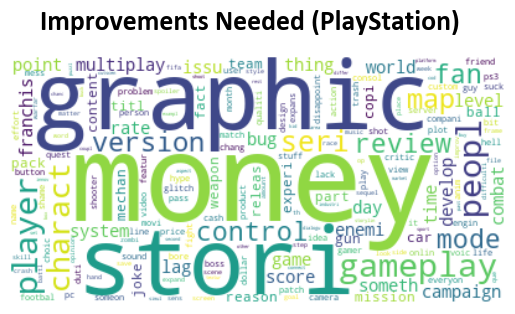

[('money', 211.4), ('graphic', 210.3), ('stori', 206.3), ('gameplay', 187.96), ('player', 184.78), ('peopl', 182.75), ('charact', 155.22), ('seri', 129.39), ('map', 113.81), ('version', 113.04), ('review', 107.17), ('mode', 106.18), ('control', 102.89), ('fan', 100.38), ('multiplay', 98.6), ('bug', 96.26), ('system', 95.37), ('someth', 94.65), ('point', 90.2), ('world', 86.06)]


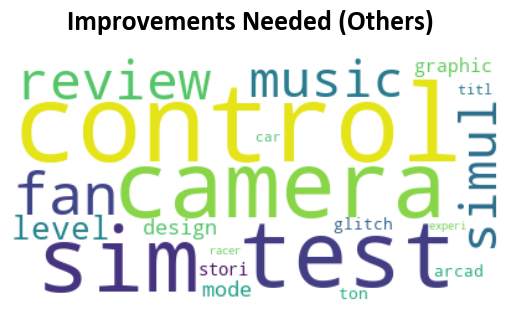

[('control', 2.75), ('camera', 2.03), ('test', 2.0), ('sim', 1.97), ('fan', 1.81), ('review', 1.49), ('simul', 1.37), ('music', 1.34), ('level', 1.23), ('design', 1.01), ('mode', 0.96), ('graphic', 0.96), ('stori', 0.86), ('glitch', 0.78), ('ton', 0.78), ('arcad', 0.75), ('titl', 0.66), ('car', 0.52), ('experi', 0.36), ('racer', 0.36)]
CPU times: total: 30min 12s
Wall time: 33min 49s


In [9]:
%%time

# Can adjust the parameters in this function to fine tune and iterate testings. Can adjust score bins, sample size and filter list above too!
# If ngrams = True, preProcessingFunctionBoolean needs to be True

for df in userCommentsTESTExtreme_list:
    for platform in platformCondensed_list:
            if df.scoreBin.max() == 'High':
                features_improvements = 'Key Features'
            elif df.scoreBin.max() == 'Low':
                features_improvements = 'Improvements Needed'
            try:
                wc(df = df[df.platformCondensed == platform], columnName = 'Comment',
                preProcessingFunctionBoolean = True, vectorizerMinDf = 2, vectorizerMaxDf = 0.7,
                countVectorizerBinary = True, tfidfVectorizerBoolean = True,
                ngrams = False, ngramsNumber = 3, furtherPreProcessNgrams = False,
                nounTaggingBoolean = True, universalNounTagsetBoolean = False,
                top = 20, features_improvements = features_improvements, platform = platform)
            except ValueError:
                print(f"\n\nNo Word Cloud for '{features_improvements} ({platform})' due to insufficient sample size (No. of comments = 0 or < vectorizerMinDf).\n\n")